## Inference

In [1]:

import time
from torchvision import models as Models
from os import path as osp
import os
from typing import List

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision

import sys
import torch.utils.data as data
import cv2
import numpy as np
from utils_yolo.augmentations import Yolov1Augmentation
from utils_yolo.dataset import VOCDetection, detection_collate, VOC_CLASSES
from utils_yolo.lr_scheduler import WarmUpMultiStepLR

import torch
from matplotlib import pyplot as plt
from torchvision import transforms
import PIL
from PIL import Image
import numpy as np
from os import path as osp
import os
from numpy.random import shuffle
from utils_yolo.predict import draw_box

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHANNEL_MEANS = (104, 117, 123)

YOLOv1_PIC_SIZE = 448
voc_data_set_root = "/home/vankhoa/datasets/VOCtrainval_11-May-2012/VOCdevkit"
MODEL_SAVE_DIR = '/home/vankhoa/code/Object_detection/YOLOv1-Pytorch/model'
test_img_dir = '/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
GRID_NUM = 7

batch_size = 4
num_workers = 8
save_step = 500
backbone = "resnet50"

In [5]:
dataset = VOCDetection(root=voc_data_set_root,
                            image_sets=(('2007', 'trainval'), ('2012', 'trainval')),
                            transform=Yolov1Augmentation(size=448, percent_coord=True))

In [6]:
dataloader = data.DataLoader(dataset,
                            batch_size,
                            num_workers=num_workers,
                            shuffle=True,
                            collate_fn=detection_collate,
                            pin_memory=False)

In [7]:

def get_backbone(model_name: str):
    r"""
    get pre-trained base-network for yolo-v1,
    children[:5] do not require grad
    :param model_name: name of model
    :return: pre-layer of pre-trained model without FC
    """

    # when input shape is [, 3, 448, 448], output shape is:
    features = list(Models.resnet50(True).children())[:-2]
    for parameters in [feature.parameters() for i, feature in enumerate(features) if i <= 4]:
        for parameter in parameters:
            parameter.requires_grad = False
    return nn.Sequential(*features), (2048, 14, 14)


class Yolov1(nn.Module):
    def __init__(self, backbone_name: str, grid_num=GRID_NUM, model_save_dir=MODEL_SAVE_DIR):
        def get_tuple_multiplied(input_tuple: tuple):
            res = 1.0
            for i in input_tuple:
                res *= i
            return int(res)

        super(Yolov1, self).__init__()
        self.model_save_dir = model_save_dir
        self.grid_num = grid_num
        self.backbone, feature_maps_shape = get_backbone(backbone_name)
        self.model_save_name = '{}_{}'.format(self.__class__.__name__, backbone_name)
        last_conv3x3_out_channel = 1024
        self.last_conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels=feature_maps_shape[0], out_channels=last_conv3x3_out_channel,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(last_conv3x3_out_channel)
        )
        self.cls = nn.Sequential(
            nn.Linear(get_tuple_multiplied((last_conv3x3_out_channel, self.grid_num, self.grid_num)), 4096),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(4096, int(self.grid_num * self.grid_num * 30)),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.last_conv3x3(x)
        x = x.view(x.size(0), -1)
        x = self.cls(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.grid_num, self.grid_num, 30)
        return x

    def save_model(self, step=None, optimizer=None, lr_scheduler=None):
        self.save_safely(self.state_dict(), self.model_save_dir, self.model_save_name + '.pkl')
        print('*** model weights saved successfully at {}!'.format(
            osp.join(self.model_save_dir, self.model_save_name + '.pkl')))
        if optimizer and lr_scheduler and step is not None:
            temp = {
                'step': step,
                'lr_scheduler': lr_scheduler.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            self.save_safely(temp, self.model_save_dir, self.model_save_name + '_para.pkl')
            print('*** auxiliary part saved successfully at {}!'.format(
                osp.join(self.model_save_dir, self.model_save_name + '.pkl')))

    def load_model(self, optimizer=None, lr_scheduler=None):
        try:
            saved_model = torch.load(osp.join(self.model_save_dir, self.model_save_name + '.pkl'),
                                     map_location='cpu')
            self.load_state_dict(saved_model)
            print('*** loading model weight successfully!')
        except Exception:
            print('*** loading model weight fail!')

        if optimizer and lr_scheduler is not None:
            try:
                temp = torch.load(osp.join(self.model_save_dir, self.model_save_name + '_para.pkl'), map_location='cpu')
                lr_scheduler.load_state_dict(temp['lr_scheduler'])
                step = temp['step']
                print('*** loading optimizer&lr_scheduler&step successfully!')
                return step
            except Exception:
                print('*** loading optimizer&lr_scheduler&step fail!')
                return 0

In [15]:
def predict(img_tensor, model, DEVICE='cuda'):
    model.eval()
    img_tensor, model = img_tensor.to(DEVICE), model.to(DEVICE)
    with torch.no_grad():
        out = model(img_tensor)
        # out:list[tensor[, 5]]
        out = decoder(out, obj_thres=0.3)
        boxes, tags, scores = [], [], []
        for cls, pred_target in enumerate(out):
            if pred_target.shape[0] > 0:
                # print(pred_target.shape)
                b = pred_target[:, :4]
                p = pred_target[:, 4]
                # print(b, p)
                keep_idx, count = _nms(b, p, overlap=0.5)
                # keep:[, 5]
                keep = pred_target[keep_idx]
                for box in keep[..., :4]: boxes.append(box)
                for tag in range(count): tags.append(torch.LongTensor([cls]))
                for score in keep[..., 4]: scores.append(score)
        # print(f'*** boxes:{boxes}\ntags:{tags}\nscores:{scores}')
        if len(boxes) > 0:
            boxes = torch.stack(boxes, 0).numpy()  # .squeeze(dim=0)
            tags = torch.stack(tags, 0).numpy()  # .squeeze(dim=0)
            scores = torch.stack(scores, 0).numpy()  # .squeeze(dim=0)
            # print(f'*** boxes:{boxes}\ntags:{tags}\nscores:{scores}')
        else:
            boxes = torch.FloatTensor([])
            tags = torch.LongTensor([])  # .squeeze(dim=0)
            scores = torch.FloatTensor([])  # .squeeze(dim=0)
        # img, boxes, tags, scores = np.array(img), np.array(boxes), np.array(tags), np.array(scores)
        return boxes, tags, scores

In [16]:
def _nms(boxes, scores, overlap=0.5, top_k=None):
    r"""
    Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """
    # boxes = boxes.detach()
    # keep shape [num_prior] type: Long
    keep = scores.new(scores.size(0)).zero_().long()
    # print('keep.shape:{}'.format(keep.shape))
    # tensor.numel()用于计算tensor里面包含元素的总数，i.e. shape[0]*shape[1]...
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    # print('x1:{}\ny1:{}\nx2:{}\ny2:{}'.format(x1, y1, x2, y2))
    # area shape[prior_num], 代表每个prior框的面积
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    # print(f'idx:{idx}')
    # I = I[v >= 0.01]
    if top_k is not None:
        # indices of the top-k largest vals
        idx = idx[-top_k:]
    # keep = torch.Tensor()
    count = 0
    # Returns the total number of elements in the input tensor.
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        # torch.index_select(input, dim, index, out=None)
        # 将input里面dim维度上序号为idx的元素放到out里面去
        # >>> x
        # tensor([[1, 2, 3],
        #         [3, 4, 5]])
        # >>> z=torch.index_select(x,0,torch.tensor([1,0]))
        # >>> z
        # tensor([[3, 4, 5],
        #         [1, 2, 3]])
        xx1 = x1[idx]
        # torch.index_select(x1, 0, idx, out=xx1)
        yy1 = y1[idx]
        # torch.index_select(y1, 0, idx, out=yy1)
        xx2 = x2[idx]
        # torch.index_select(x2, 0, idx, out=xx2)
        yy2 = y2[idx]
        # torch.index_select(y2, 0, idx, out=yy2)

        # store element-wise max with next highest score
        # 将除置信度最高的prior框外的所有框进行clip以计算inter大小
        # print(f'xx1.shape:{xx1.shape}')
        xx1 = torch.clamp(xx1, min=float(x1[i]))
        yy1 = torch.clamp(yy1, min=float(y1[i]))
        xx2 = torch.clamp(xx2, max=float(x2[i]))
        yy2 = torch.clamp(yy2, max=float(y2[i]))
        # w.resize_as_(xx2)
        # h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w * h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter / union  # store result in iou
        # keep only elements with an IoU <= overlap
        # torch.le===>less and equal to
        idx = idx[IoU.le(overlap)]
    # print(keep, count)
    # keep 包含置信度从大到小的prior框的indices，count表示数量
    # print('keep.shape:{},count:{}'.format(keep.shape, count))
    return keep, count

In [17]:
def decoder(pred, obj_thres=0.1):
    r"""
    :param pred: the output of the yolov1 model, should be tensor of [1, grid_num, grid_num, 30]
    :param obj_thres: the threshold of objectness
    :return: list of [c, [boxes, labels]], boxes is [:4], labels is [4]
    """
    pred = pred.cpu()
    assert pred.shape[0] == 1
    # i for W, j for H
    res = [[] for i in range(len(VOC_CLASSES))]
    # print(res)
    for h in range(GRID_NUM):
        for w in range(GRID_NUM):
            better_box = pred[0, h, w, :5] if pred[0, h, w, 4] > pred[0, h, w, 9] else pred[0, h, w, 5:10]
            if better_box[4] < obj_thres:
                continue
            better_box_xyxy = torch.FloatTensor(better_box.size())
            # print(f'grid(cx,cy), (w,h), obj:{better_box}')
            better_box_xyxy[:2] = better_box[:2] / float(GRID_NUM) - 0.5 * better_box[2:4]
            better_box_xyxy[2:4] = better_box[:2] / float(GRID_NUM) + 0.5 * better_box[2:4]
            better_box_xyxy[0:4:2] += (w / float(GRID_NUM))
            better_box_xyxy[1:4:2] += (h / float(GRID_NUM))
            better_box_xyxy = better_box_xyxy.clamp(max=1.0, min=0.0)
            score, cls = pred[0, h, w, 10:].max(dim=0)
            # print(f'pre_cls_shape:{pred[0, w, h, 10:].shape}')
            # from dataset import VOC_CLASSES as LABELS
            # print(f'score:{score}\tcls:{cls}\ttag:{LABELS[cls]}')
            better_box_xyxy[4] = score * better_box[4]
            res[cls].append(better_box_xyxy)
    # print(res)
    for i in range(len(VOC_CLASSES)):
        if len(res[i]) > 0:
            # res[i] = [box.unsqueeze(0) for box in res[i]]
            res[i] = torch.stack(res[i], 0)
        else:
            res[i] = torch.tensor([])
    # print(res)
    return res

In [18]:
def img_to_tensor_batch(img_path, size=(448, 448)):
    img = Image.open(img_path)
    img_resize = img.resize(size, PIL.Image.BILINEAR)
    img_tensor = transforms.ToTensor()(img_resize).unsqueeze(0)
    # print(f'img_tensor:{img_tensor.shape}')
    # print(f'img_tensor:{img_tensor}')
    return img_tensor, img

In [19]:
def predict_one_img(img_path, model):
    img_tensor, img = img_to_tensor_batch(img_path)
    boxes, tags, scores = predict(img_tensor, model, DEVICE=DEVICE)
    img = np.array(img)
    draw_box(img_np=img, boxes_np=boxes, scores_np=scores, tags_np=tags, relative_coord=True)

In [22]:
model = Yolov1(backbone_name='resnet50')
model.load_model()

*** loading model weight successfully!


/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages [] ['009779.jpg', '003411.jpg', '006274.jpg', '008677.jpg', '003329.jpg']
*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005382.jpg


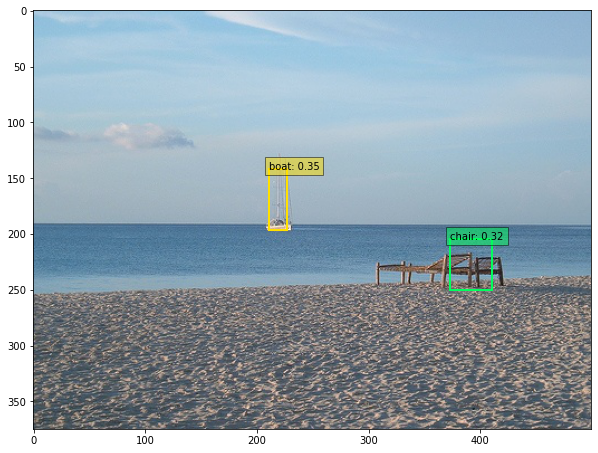

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/003029.jpg


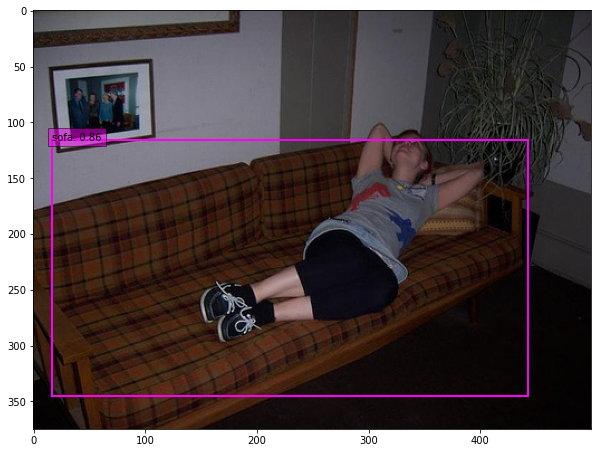

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000022.jpg


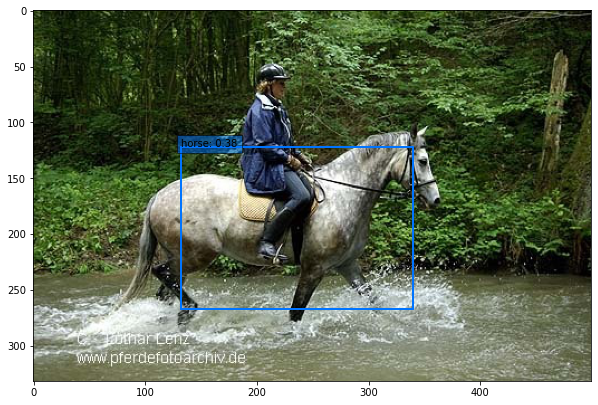

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/007143.jpg


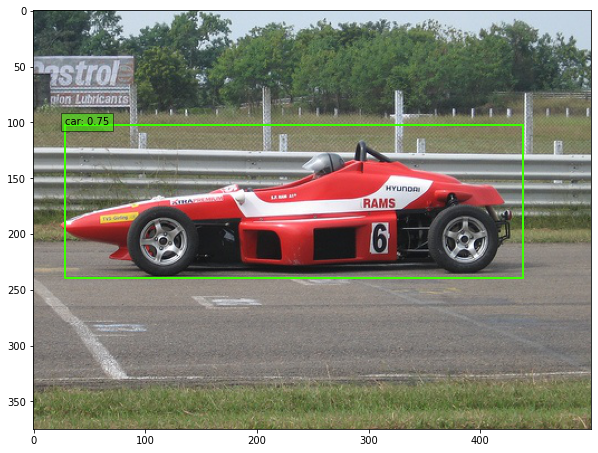

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/008895.jpg


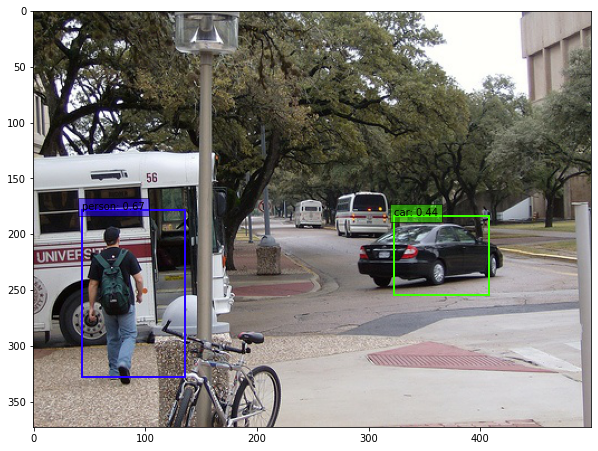

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/008686.jpg


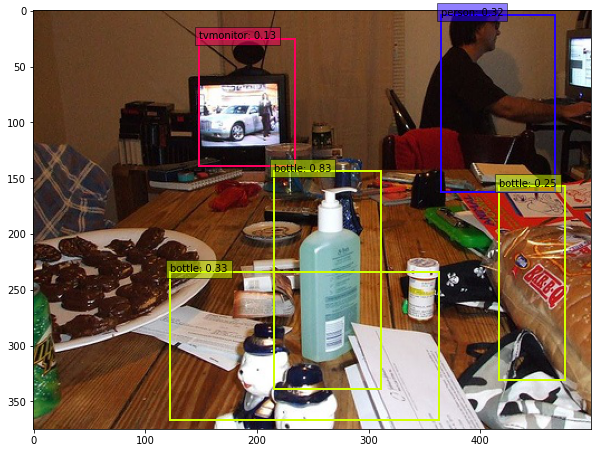

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/004738.jpg


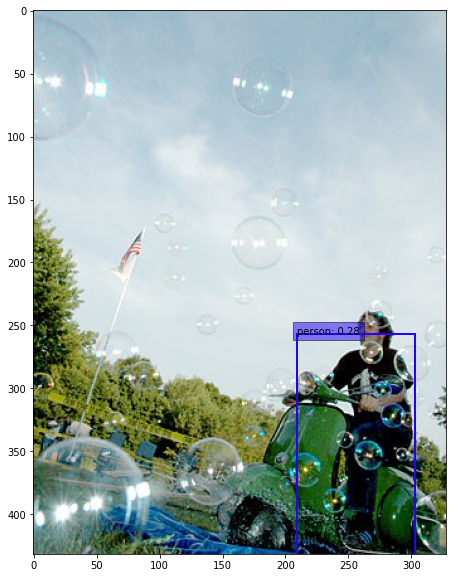

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005595.jpg


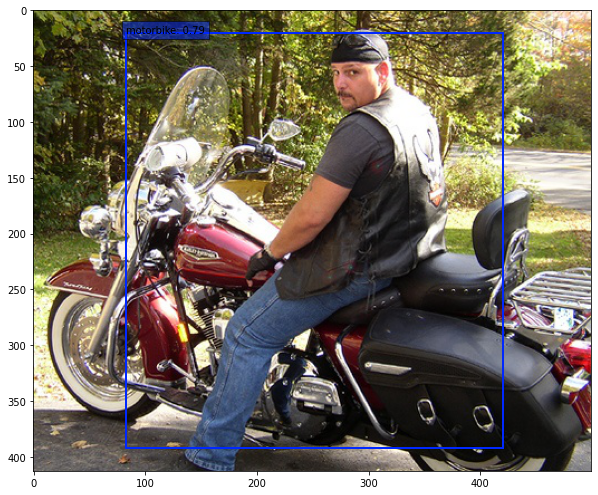

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/008339.jpg


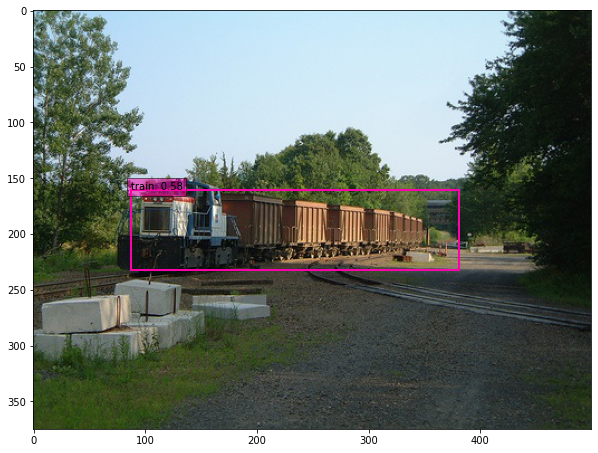

*** testing:/home/vankhoa/datasets/archive/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000126.jpg


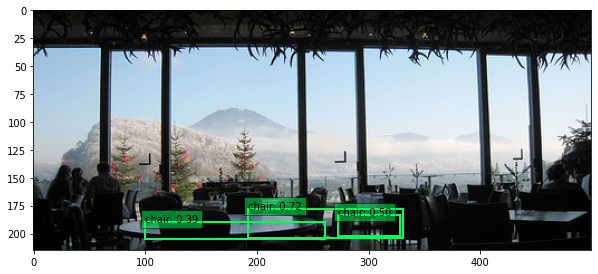

In [23]:
for root, dirs, files in os.walk(test_img_dir, topdown=True):
    if test_img_dir == root:
        print(root, dirs, files[:5])
        files = [i for i in files if any([j in i for j in ['jpg', 'png', 'jpeg', 'gif', 'tiff']])]
        shuffle(files)
        for file in files[:10]:
            file_path = os.path.join(root, file)
            print(f'*** testing:{file_path}')
            predict_one_img(file_path, model)